In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Install the Kaggle library
! pip install kaggle

# Make a directory named “.kaggle”
! mkdir ~/.kaggle

# Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

# Allocate the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

# The colab notebook is now ready to download datasets from Kaggle

In [ ]:
!apt-get update
!apt-get install -y apt-utils
!apt-get install unzip


In [ ]:
# Load Flickr8k dataset from Kaggle and save to Google Drive
! kaggle datasets download adityajn105/flickr30k
! unzip -q flickr30k.zip


In [ ]:
! pip install pandas
! pip install sentencepiece
! pip install matplotlib
! pip install scikit-learn
! pip install nltk


In [3]:
import os
import math
import random
import pickle
import textwrap

import pandas as pd
import numpy as np
import sentencepiece as spm
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

In [109]:
device = torch.device("cpu")
print(f"Running on {device}")

Running on cpu


In [111]:
# Paths - local CPU
current_directory = os.getcwd()

image_path = current_directory \
        + '/gdrive/My Drive/Colab Data/Flickr30k Dataset/Images/'
annotations_path = current_directory \
        + '/gdrive/My Drive/Colab Data/Flickr30k Dataset/flickr_annotations_30k.csv'

working_directory = current_directory \
        + '/gdrive/My Drive/Colab Notebooks/Multimodal Transformers for Image Captioning/'

spm_model = working_directory + 'spm.model'


In [110]:
# Paths - remote GPU
current_directory = os.getcwd()

image_path = current_directory \
        + '/Images/'
annotations_path = current_directory \
        + '/flickr_annotations_30k.csv'

working_directory = current_directory

spm_model = working_directory + '/spm.model'


In [5]:
# Preview the Flickr8k captions
annotations = pd.read_csv(annotations_path)
print(annotations.head())
print(annotations.info())

pd.set_option('display.max_colwidth', None)
print(annotations[:10])


                                                 raw               sentids  \
0  ["Two young guys with shaggy hair look at thei...       [0, 1, 2, 3, 4]   
1  ["Several men in hard hats are operating a gia...       [5, 6, 7, 8, 9]   
2  ["A child in a pink dress is climbing up a set...  [10, 11, 12, 13, 14]   
3  ["Someone in a blue shirt and hat is standing ...  [15, 16, 17, 18, 19]   
4  ["Two men, one in a gray shirt, one in a black...  [20, 21, 22, 23, 24]   

   split        filename  img_id  
0  train  1000092795.jpg       0  
1  train    10002456.jpg       1  
2  train  1000268201.jpg       2  
3  train  1000344755.jpg       3  
4  train  1000366164.jpg       4  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   raw       31014 non-null  object
 1   sentids   31014 non-null  object
 2   split     31014 non-null  object
 3   filename  31014 no

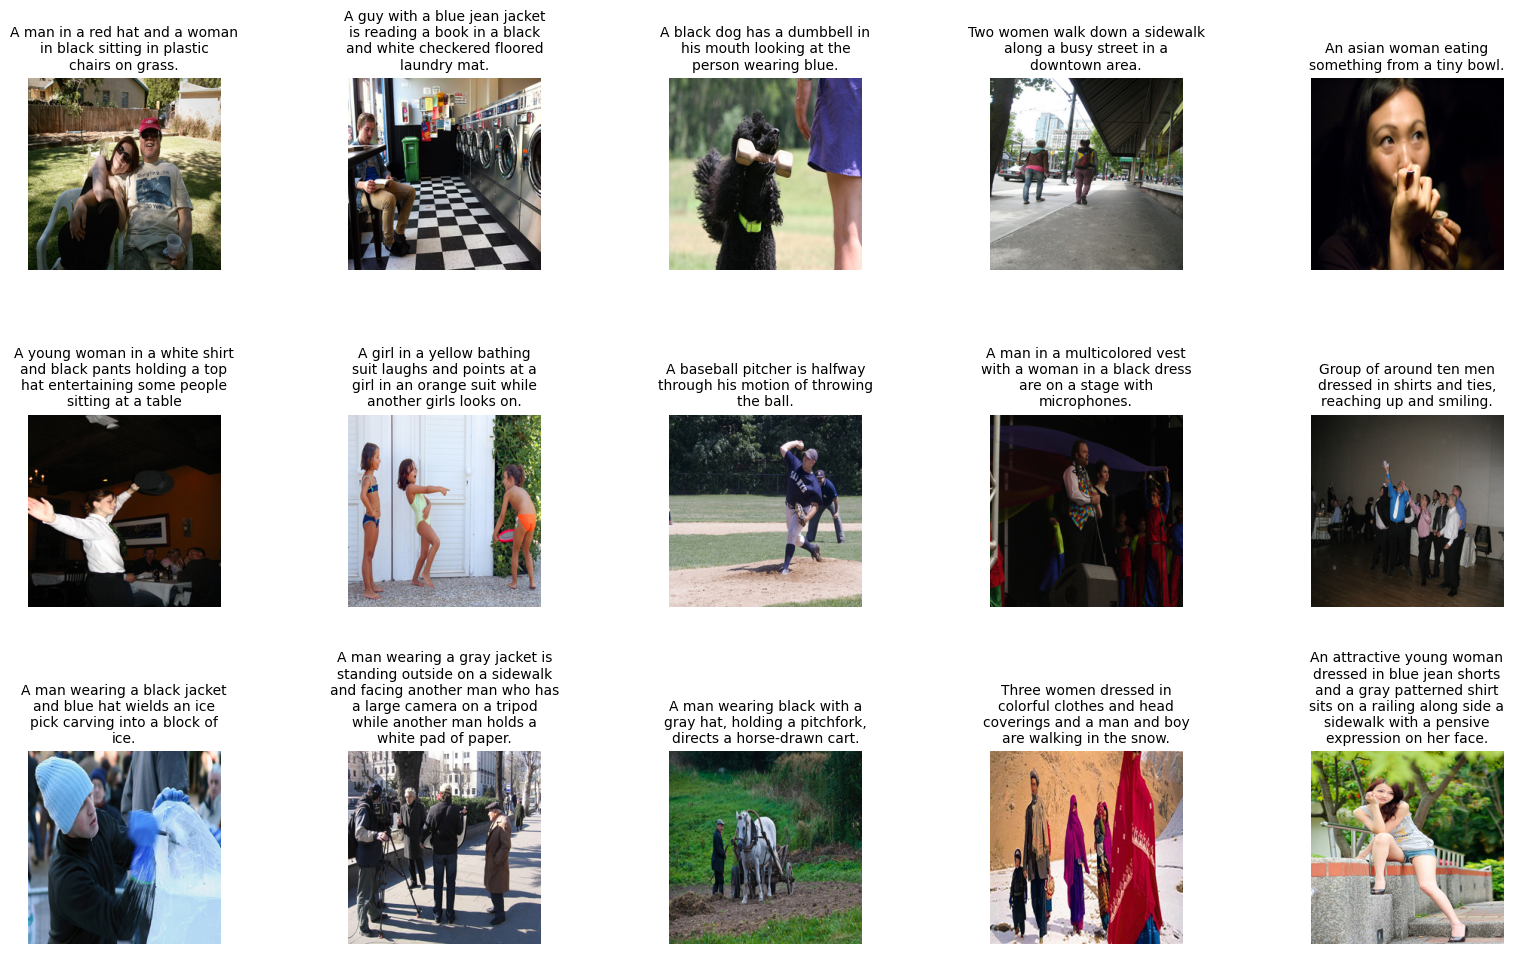

In [24]:
def read_image(path, img_size=256):
    # Load and resize an image in square format
    # and convert it to an array representation
    img = Image.open(path).resize((img_size, img_size))
    img_array = np.array(img)
    normalized_img_array = img_array / 255.0
    return normalized_img_array


def show_sample_images(df):
    # Display a set of images and an associated caption

    df = df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))

    for i in range(len(df)):
        plt.subplot(5 , 5, i+1)
        plt.subplots_adjust(hspace=0.75)
        image = read_image(image_path + df.filename[i])
        caption = df.raw[i][0]
        text = textwrap.fill(caption, 30)

        plt.imshow(image)
        plt.title(text, fontsize=10)
        plt.axis("off")
    return


# Load and pre-process image captions
annotations = pd.read_csv(annotations_path)
annotations.raw = annotations.raw.apply(lambda caption_str: eval(caption_str))

# Create a random sample of images and display
show_sample_images(annotations.sample(15))


31014

--- Flickr8k Dataset Captions ---------------------------------
A soccer player in red being tackled by a soccer player in green.
A player tackling his opponent in a game of rugby.
A soccer player is being tackled by his opponent
A man is about to be tackled in the rugby game.
Rugby players tackling each other.




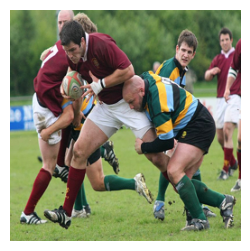

In [25]:
def read_image(path, img_size=256):
    # Load and resize an image in square format
    # and convert it to an array representation
    img = Image.open(path).resize((img_size, img_size))
    img_array = np.array(img)
    normalized_img_array = img_array / 255.0
    return normalized_img_array


# Create a random image and display
print(len(annotations))
df = annotations.sample(1)
df = df.reset_index(drop=True)

print('\n--- Flickr8k Dataset Captions ---------------------------------')
for i in range(len(df.raw[0])):
    print(df.raw[0][i])

print("\n")
plt.figure(figsize=(3,3))
image = read_image(image_path + df.filename[0])
plt.imshow(image)
plt.axis('off')
plt.show()


Create a dataframe of image_id to caption. There are multiple captions for each image_id.

In [6]:
# Specify datatypes for a new DataFrame

data_types = {
    'raw': 'str',
    'filename': 'str'
}

# Read the the image_ids and captions into a Dataframe
image_caption_data = pd.read_csv(annotations_path, usecols=['raw', 'filename'], dtype=data_types)
image_caption_data = image_caption_data[['filename', 'raw']]

# Splitting the 'captions' column to create separate rows for each sentence
image_caption_data['raw'] = image_caption_data['raw'].str.strip('[]"').str.split('", "')

# Duplicating the 'image_id' for each row
image_caption_data = image_caption_data.explode('raw')

# Renaming the columns
image_caption_data.columns = ['image_id', 'caption']

# Resetting the index
image_caption_data.reset_index(drop=True, inplace=True)

print(image_caption_data)
print(f"Total number of captions: {len(image_caption_data)}")


# Summary stats on caption data
caption_lengths = image_caption_data['caption'].str.len()

# Get summary statistics for the string lengths
summary_stats = caption_lengths.describe()

# Additional statistics
max_length = caption_lengths.max()
min_length = caption_lengths.min()
average_length = caption_lengths.mean()
std_dev_length = caption_lengths.std()

# Percentile length (e.g., 90th percentile)
percentile_90 = caption_lengths.quantile(0.90)

# Print the summary statistics
print("Summary Statistics:")
print(summary_stats)
print("\nAdditional Statistics:")
print(f"Maximum Length: {max_length}")
print(f"Minimum Length: {min_length}")
print(f"Average Length: {average_length}")
print(f"Standard Deviation Length: {std_dev_length}")
print(f"90th Percentile Length: {percentile_90}")





              image_id  \
0       1000092795.jpg   
1       1000092795.jpg   
2       1000092795.jpg   
3       1000092795.jpg   
4       1000092795.jpg   
...                ...   
155065   998845445.jpg   
155066   998845445.jpg   
155067   998845445.jpg   
155068   998845445.jpg   
155069   998845445.jpg   

                                                                                                                    caption  
0                                        Two young guys with shaggy hair look at their hands while hanging out in the yard.  
1                                                                      Two young, White males are outside near many bushes.  
2                                                                           Two men in green shirts are standing in a yard.  
3                                                                               A man in a blue shirt standing in a garden.  
4                                                        

In [ ]:
# Verify that images exist for all captions
rows_dropped = 0
for index, row in tqdm(image_caption_data.iterrows()):
    filename = row['image_id']
    file_path = os.path.join(image_path, filename)

    if not os.path.exists(file_path):
        # Delete the row if the file doesn't exist
        rows_dropped += 1
        image_caption_data.drop(index, inplace=True)

# Reset the index after dropping rows
image_caption_data.reset_index(drop=True, inplace=True)

print(f"Image IDs verified. Number of rows dropped: {rows_dropped}")
print(f"Total number of captions: {len(image_caption_data)}")


In [7]:
# Create datasets for training, validation and testing
train_data, temp_data = train_test_split(image_caption_data, test_size=0.2, random_state=42)

# Split the remaining data into train and validation sets
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)


print(f'Complete dataset:{len(image_caption_data)}')
print(f'Train dataset:{len(train_data)}')
print(f'Validation dataset:{len(val_data)}')
print(f'Test dataset:{len(test_data)}')

# Save datasets to pickle
pickle.dump(train_data,
            open(f'{working_directory}train_data.pkl', 'wb'))
pickle.dump(val_data,
            open(f'{working_directory}val_data.pkl', 'wb'))
pickle.dump(test_data,
            open(f'{working_directory}test_data.pkl', 'wb'))


Complete dataset:155070
Train dataset:124056
Validation dataset:20779
Test dataset:10235


In [7]:
# Load datasets from pickle
with open(f'{working_directory}train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(f'{working_directory}val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open(f'{working_directory}test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)


In [8]:
# Load pre-trained SentencePiece tokenizer
sp = spm.SentencePieceProcessor()
sp.load(spm_model)

# Get the actual vocabulary size
vocab_size = sp.get_piece_size()

# Print the actual vocabulary size
print("Actual vocabulary size:", vocab_size)


Actual vocabulary size: 16000


In [9]:
def preprocess_image(img_id, img_size=256, patch_size=16):

    # Pre-processing image as an array of normalized pixel values
    file_path = os.path.join(image_path, img_id)
    img = Image.open(file_path).resize((img_size, img_size))
    img_array = np.array(img)
    img_array = img_array / 255.0

    # reshape into patches
    patch_height = img_array.shape[0] // patch_size
    patch_width = img_array.shape[1] // patch_size
    patches = np.reshape(img_array, (patch_height, patch_size, patch_width, patch_size, img_array.shape[2]))
    patches = np.transpose(patches, (0, 2, 1, 3, 4))
    patches = np.reshape(patches, (-1, patch_size, patch_size, img_array.shape[2]))

    # Flatten the patches
    patches = np.reshape(patches, (patches.shape[0], -1))
    #patches = np.expand_dims(patches, axis=0)  # Added dimension to specify batch size

    return patches


In [10]:
class CustomDataset(Dataset):
    def __init__(self, img_cap_data, sp_model):
        self.img_cap_data = img_cap_data
        self.sp = sp_model

    def __len__(self):
        return len(self.img_cap_data)

    def __getitem__(self, idx):

        # Preprocess images and captions
        image_encoded = preprocess_image(self.img_cap_data.iloc[idx]['image_id'])
        X1_tensor = torch.tensor(image_encoded)
        caption_encoded = self.sp.encode(self.img_cap_data.iloc[idx]['caption'])

        # Add <s> and </s> tokens
        X2_tensor = torch.tensor([1] + caption_encoded)
        y_tensor = torch.tensor(caption_encoded + [2])

        return [X1_tensor, X2_tensor, y_tensor]


In [11]:
class MultiHeadAttention(nn.Module):
    '''
    d_model: Dimensionality of the input.
    num_heads: The number of attention heads to split the input into.
    The initialization checks if d_model is divisible by num_heads, and then
    defines the transformation weights for query, key, value, and output.

    The MultiHeadAttention class encapsulates the multi-head attention
    mechanism commonly used in transformer models. It takes care of splitting the
    input into multiple attention heads, applying attention to each head, and then
    combining the results. By doing so, the model can capture various relationships
    in the input data at different scales, improving the expressive ability of the
    model.
    '''
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        '''
        Calculating Attention Scores: attn_scores = torch.matmul(Q,
        K.transpose(-2, -1)) / math.sqrt(self.d_k).
        Here, the attention scores are calculated by taking the dot product of
        queries (Q) and keys (K), and then scaling by the square root of the key
        dimension (d_k).
        Applying Mask: If a mask is provided, it is applied to the attention
        scores to mask out specific values.
        Calculating Attention Weights: The attention scores are passed through a
        softmax function to convert them into probabilities that sum to 1.
        Calculating Output: The final output of the attention is calculated by
        multiplying the attention weights by the values (V).
        '''
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        '''
        This method reshapes the input x into the shape (batch_size, num_heads,
        seq_length, d_k).
        It enables the model to process multiple attention heads concurrently,
        allowing for parallel computation.
        '''
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        '''
        After applying attention to each head separately, this method combines
        the results back into a single tensor of shape (batch_size, seq_length,
        d_model). This prepares the result for further processing.
        '''
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        '''
        The forward method is where the actual computation happens:
        - Apply Linear Transformations: The queries (Q), keys (K), and values (V)
        are first passed through linear transformations using the weights defined
        in the initialization.
        - Split Heads: The transformed Q, K, V are split into multiple heads
        using the split_heads method.
        - Apply Scaled Dot-Product Attention: The scaled_dot_product_attention
        method is called on the split heads.
        - Combine Heads: The results from each head are combined back into a
        single tensor using the combine_heads method.
        - Apply Output Transformation: Finally, the combined tensor is passed
        through an output linear transformation.
        '''

        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [12]:
class PositionWiseFeedForward(nn.Module):
    '''
    The class is a subclass of PyTorch's nn.Module, which means it will inherit
    all functionalities required to work with neural network layers.

    The PositionWiseFeedForward class defines a position-wise feed-forward neural
    network that consists of two linear layers with a ReLU activation function in
    between. In the context of transformer models, this feed-forward network is
    applied to each position separately and identically. It helps in transforming
    the features learned by the attention mechanisms within the transformer, acting
    as an additional processing step for the attention outputs.
    '''
    def __init__(self, d_model, d_ff):
        '''
        - d_model: Dimensionality of the model's input and output.
        - d_ff: Dimensionality of the inner layer in the feed-forward network.
        - self.fc1 and self.fc2: Two fully connected (linear) layers with input
        and output dimensions as defined by d_model and d_ff.
        - self.relu: ReLU (Rectified Linear Unit) activation function, which
        introduces non-linearity between the two linear layers.
        '''
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        '''
        x: The input to the feed-forward network.
        self.fc1(x): The input is first passed through the first linear layer (fc1).
        self.relu(...): The output of fc1 is then passed through a ReLU activation
        function. ReLU replaces all negative values with zeros, introducing
        non-linearity into the model.
        self.fc2(...): The activated output is then passed through the second
        linear layer (fc2), producing the final output.
        '''
        return self.fc2(self.relu(self.fc1(x)))

In [13]:
class PositionalEncoding(nn.Module):
    '''
    Positional Encoding is used to inject the position information of each token
    in the input sequence. It uses sine and cosine functions of different
    frequencies to generate the positional encoding.

    The PositionalEncoding class adds information about the position of tokens
    within the sequence. Since the transformer model lacks inherent knowledge of
    the order of tokens (due to its self-attention mechanism), this class helps
    the model to consider the position of tokens in the sequence. The sinusoidal
    functions used are chosen to allow the model to easily learn to attend to
    relative positions, as they produce a unique and smooth encoding for each
    position in the sequence.
    '''
    def __init__(self, d_model, max_seq_length):
        '''
        - d_model: The dimension of the model's input.
        - max_seq_length: The maximum length of the sequence for which positional
        encodings are pre-computed.
        - pe: A tensor filled with zeros, which will be populated with positional
        encodings.
        - position: A tensor containing the position indices for each position in
        the sequence.
        - div_term: A term used to scale the position indices in a specific way.
        - The sine function is applied to the even indices and the cosine function
        to the odd indices of pe.
        - Finally, pe is registered as a buffer, which means it will be part of the
        module's state but will not be considered a trainable parameter.
        '''
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        '''
        The forward method simply adds the positional encodings to the input x.
        It uses the first x.size(1) elements of pe to ensure that the positional
        encodings match the actual sequence length of x.
        '''
        return x + self.pe[:, :x.size(1)]

In [14]:
class EncoderLayer(nn.Module):
    '''
    The EncoderLayer class defines a single layer of the transformer's encoder.
    It encapsulates a multi-head self-attention mechanism followed by position-wise
    feed-forward neural network, with residual connections, layer normalization,
    and dropout applied as appropriate. These components together allow the encoder
    to capture complex relationships in the input data and transform them into a
    useful representation for downstream tasks. Typically, multiple such encoder
    layers are stacked to form the complete encoder part of a transformer model.
    '''
    def __init__(self, d_model, num_heads, d_ff, dropout):
        '''
        Parameters:

        - d_model: The dimensionality of the input.
        - num_heads: The number of attention heads in the multi-head attention.
        - d_ff: The dimensionality of the inner layer in the position-wise
        feed-forward network.
        - dropout: The dropout rate used for regularization.

        Components:

        - self.self_attn: Multi-head attention mechanism.
        - self.feed_forward: Position-wise feed-forward neural network.
        - self.norm1 and self.norm2: Layer normalization, applied to smooth the
        layer's input.
        - self.dropout: Dropout layer, used to prevent overfitting by randomly
        setting some activations to zero during training.
        '''
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        '''
        Input:

        - x: The input to the encoder layer.
        - mask: Optional mask to ignore certain parts of the input.

        Processing Steps:

        - Self-Attention: The input x is passed through the multi-head
        self-attention mechanism.
        - Add & Normalize (after Attention): The attention output is added to the
        original input (residual connection), followed by dropout and normalization
        using norm1.
        - Feed-Forward Network: The output from the previous step is passed through
        the position-wise feed-forward network.
        - Add & Normalize (after Feed-Forward): Similar to step 2, the feed-forward
        output is added to the input of this stage (residual connection), followed by dropout and normalization using norm2.
        - Output: The processed tensor is returned as the output of the encoder
        layer.
        '''

        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [15]:
class DecoderLayer(nn.Module):
    '''
    The DecoderLayer class defines a single layer of the transformer's decoder.
    It consists of a multi-head self-attention mechanism, a multi-head
    cross-attention mechanism (that attends to the encoder's output), a
    position-wise feed-forward neural network, and the corresponding residual
    connections, layer normalization, and dropout layers. This combination enables
    the decoder to generate meaningful outputs based on the encoder's
    representations, taking into account both the target sequence and the source
    sequence. As with the encoder, multiple decoder layers are typically stacked
    to form the complete decoder part of a transformer model.
    '''
    def __init__(self, d_model, num_heads, d_ff, dropout):
        '''
        Parameters:

        - d_model: The dimensionality of the input.
        - num_heads: The number of attention heads in the multi-head attention.
        - d_ff: The dimensionality of the inner layer in the feed-forward network.
        - dropout: The dropout rate for regularization.

        Components:

        - self.self_attn: Multi-head self-attention mechanism for the target
        sequence.
        - self.cross_attn: Multi-head attention mechanism that attends to the
        encoder's output.
        - self.feed_forward: Position-wise feed-forward neural network.
        - self.norm1, self.norm2, self.norm3: Layer normalization components.
        - self.dropout: Dropout layer for regularization.
        '''
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    #def forward(self, x, enc_output, src_mask, tgt_mask):
    def forward(self, x, tgt_mask):
        '''
        Input:

        - x: The input to the decoder layer.
        - enc_output: The output from the corresponding encoder (used in the
        cross-attention step).
        - src_mask: Source mask to ignore certain parts of the encoder's output.
        - tgt_mask: Target mask to ignore certain parts of the decoder's input.

        Processing Steps:

        - Self-Attention on Target Sequence: The input x is processed through a
        self-attention mechanism.
        - Add & Normalize (after Self-Attention): The output from self-attention is
        added to the original x, followed by dropout and normalization using norm1.
        - Cross-Attention with Encoder Output: The normalized output from the
        previous step is processed through a cross-attention mechanism that attends
        to the encoder's output enc_output.
        - Add & Normalize (after Cross-Attention): The output from cross-attention
        is added to the input of this stage, followed by dropout and normalization
        using norm2.
        - Feed-Forward Network: The output from the previous step is passed through
        the feed-forward network.
        - Add & Normalize (after Feed-Forward): The feed-forward output is added to
        the input of this stage, followed by dropout and normalization using norm3.
        - Output: The processed tensor is returned as the output of the decoder
        layer.
        '''

        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        #attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        #x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [26]:
class Transformer(nn.Module):
    '''
    The Transformer class brings together the various components of a Transformer
    model, including the embeddings, positional encoding, encoder layers, and
    decoder layers. It provides a convenient interface for training and inference,
    encapsulating the complexities of multi-head attention, feed-forward networks,
    and layer normalization.

    This implementation follows the standard Transformer architecture, making it
    suitable for sequence-to-sequence tasks like machine translation, text
    summarization, etc. The inclusion of masking ensures that the model adheres
    to the causal dependencies within sequences, ignoring padding tokens and
    preventing information leakage from future tokens.

    These sequential steps empower the Transformer model to efficiently process
    input sequences and produce corresponding output sequences.
    '''
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        '''
        The constructor takes the following parameters:

        - src_vocab_size: Source vocabulary size.
        - tgt_vocab_size: Target vocabulary size.
        - d_model: The dimensionality of the model's embeddings.
        - num_heads: Number of attention heads in the multi-head attention
        mechanism.
        - num_layers: Number of layers for both the encoder and the decoder.
        - d_ff: Dimensionality of the inner layer in the feed-forward network.
        - max_seq_length: Maximum sequence length for positional encoding.
        - dropout: Dropout rate for regularization.

        And it defines the following components:

        - self.encoder_embedding: Embedding layer for the source sequence.
        - self.decoder_embedding: Embedding layer for the target sequence.
        - self.positional_encoding: Positional encoding component.
        - self.encoder_layers: A list of encoder layers.
        - self.decoder_layers: A list of decoder layers.
        - self.fc: Final fully connected (linear) layer mapping to target
        vocabulary size.
        = self.dropout: Dropout layer.
        '''
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        '''
        This method is used to create masks for the source and target sequences,
        ensuring that padding tokens are ignored and that future tokens are not
        visible during training for the target sequence.
        '''
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        '''
        This method defines the forward pass for the Transformer, taking source
        and target sequences and producing the output predictions.

        - Input Embedding and Positional Encoding: The source and target sequences
        are first embedded using their respective embedding layers and then added
        to their positional encodings.
        - Encoder Layers: The source sequence is passed through the encoder layers,
        with the final encoder output representing the processed source sequence.
        - Decoder Layers: The target sequence and the encoder's output are passed
        through the decoder layers, resulting in the decoder's output.
        - Final Linear Layer: The decoder's output is mapped to the target
        vocabulary size using a fully connected (linear) layer.
        - Output: The final output is a tensor representing the model's predictions
        for the target sequence.
        '''

        src_mask, tgt_mask = self.generate_mask(src, tgt)
        #src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))


        '''
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        '''

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            #dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
            dec_output = dec_layer(dec_output, tgt_mask)

        output = self.fc(dec_output)

        # Apply softmax activation function along the last dimension - DON'T THINK I SHOULD DO THIS because loss function does it!!
        #output = F.softmax(output, dim=-1)

        return output


In [27]:
def collate_fn(batch):

    # Unpack the batch into X1, X2 and y tensors
    X1_batch, X2_batch, y_batch = zip(*batch)

    # Pad sequences and labels to the same length
    stacked_X1 = torch.stack(X1_batch)
    padded_X2 = pad_sequence(X2_batch, batch_first=True, padding_value=0)
    padded_y = pad_sequence(y_batch, batch_first=True, padding_value=0)

    return stacked_X1, padded_X2, padded_y


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [106]:
# Model hyperparameters
'''
These values define the architecture and behavior of the transformer model:

- src_vocab_size, tgt_vocab_size: Vocabulary sizes for source and target sequences, both set to 16000.
- d_model: Dimensionality of the model's embeddings, set to 512.
- num_heads: Number of attention heads in the multi-head attention mechanism, set to 8.
- num_layers: Number of layers for both the encoder and the decoder, set to 6.
- d_ff: Dimensionality of the inner layer in the feed-forward network, set to 2048.
- max_seq_length: Maximum sequence length for positional encoding, set to 100.
- dropout: Dropout rate for regularization, set to 0.1.
'''
src_vocab_size = 16000
tgt_vocab_size = 16000
d_model = 256  #  256 (lo-res) or 512 (hi-res)
num_heads = 1  # 8
num_layers = 1  # 6
d_ff = 2048
max_seq_length = 100
dropout = 0

# Training hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 5


In [98]:
# Reduce size of data for testing purposes
num_train_samples = 20
mini_train_data = train_data.sample(num_train_samples)

print("MINI TRAINING DATA")
print(mini_train_data.head(5))

num_val_samples = 2
mini_val_data = val_data.sample(num_val_samples)

print("MINI VALIDATION DATA")
print(mini_val_data.head(5))

# Save datasets to pickle
pickle.dump(mini_train_data,
            open(f'{working_directory}mini_train_data.pkl', 'wb'))
pickle.dump(mini_val_data,
            open(f'{working_directory}mini_val_data.pkl', 'wb'))

MINI TRAINING DATA
             image_id  \
42505  2792254349.jpg   
72990  3543600125.jpg   
53502   308428122.jpg   
50343  3002920707.jpg   
25723  2365499852.jpg   

                                                                                                                 caption  
42505  Man in white tank top holding drumsticks and sitting in front of a drum set with a psychedelic poster behind him.  
72990                                        A woman in black is sitting next to a man wearing glasses in a coffee shop.  
53502                                                            Medical workers in uniform are gathered around a table.  
50343                                                                                        A boy and girl are dancing.  
25723                                                                                   Four women are on stage singing.  
MINI VALIDATION DATA
              image_id  \
143465  6927430969.jpg   
133452  5676066044.

In [ ]:
# Load datasets from pickle
with open(f'{working_directory}mini_train_data.pkl', 'rb') as f:
    mini_train_data = pickle.load(f)
with open(f'{working_directory}mini_val_data.pkl', 'rb') as f:
    mini_val_data = pickle.load(f)

In [107]:
# Create the datasets and the data loaders

train_dataset = CustomDataset(mini_train_data, sp)
#train_dataset = CustomDataset(train_data, sp)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = CustomDataset(mini_train_data, sp)
#val_dataset = CustomDataset(val_data, sp)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_dataset = CustomDataset(test_data, sp)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


# Create the model, loss function and optimizer
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=0)  # ignore_index=0 will ensure that padding is ignored
optimizer = Adam(transformer.parameters(), lr=learning_rate)

print(f'The model has {count_parameters(transformer):,} trainable parameters')


The model has 15,197,824 trainable parameters


In [108]:
# Training loop


# Initialize early stopping parameters
patience = 1000
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None

epoch_train_loss = []
epoch_val_loss = []
for epoch in tqdm(range(num_epochs)):

    # Training phase
    transformer.train()

    batch_train_loss = []
    for batch in train_dataloader:
        # Unpack the batch into X1, X2 and y tensors
        X1_batch, X2_batch, y_batch = batch

        optimizer.zero_grad()
        output = transformer(X1_batch, X2_batch)
        '''
        print("OUTPUT SHAPE", output.shape)
        print(output)
        '''

        output_batch = output.view(-1, output.size(2))
        y_batch = y_batch.view(-1)

        '''
        print("GOING INTO LOSS FUNCTION")
        print("OUTPUT BATCH SHAPE", output_batch.shape)
        print(output_batch)
        print("Y BATCH SHAPE", y_batch.shape)
        print(y_batch)
        '''

        loss = criterion(output_batch, y_batch)
        batch_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    # Compute training loss for the epoch
    train_loss = np.mean(batch_train_loss)
    epoch_train_loss.append(train_loss)


    # Validation phase
    transformer.eval()  # Set model to evaluation mode

    batch_val_loss = []
    with torch.no_grad():  # Disable gradient calculation during validation
        for batch in val_dataloader:

            # Unpack the batch into x and y tensors
            X1_batch, X2_batch, y_batch = batch

            output = transformer(X1_batch, X2_batch)

            output_batch = output.view(-1, output.size(2))
            y_batch = y_batch.view(-1)

            loss = criterion(output_batch, y_batch)
            batch_val_loss.append(loss.item())

    # Compute val loss for the epoch
    val_loss = np.mean(batch_val_loss)
    epoch_val_loss.append(val_loss)

    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = transformer.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Print epoch results
    print(f'Epoch {epoch+1}: Training Loss: {epoch_train_loss[-1]}, Validation Loss: {epoch_val_loss[-1]}')

    # Check for early stopping
    if epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch+1} epochs.')
        break


# Use the best model state
if best_model_state is not None:
    transformer.load_state_dict(best_model_state)
    torch.save(transformer.state_dict(), 'best_model.pth')



 10%|█         | 1/10 [00:02<00:18,  2.08s/it]

Epoch 1: Training Loss: 723.1776275634766, Validation Loss: 588.4149780273438


 20%|██        | 2/10 [00:03<00:14,  1.76s/it]

Epoch 2: Training Loss: 548.1516876220703, Validation Loss: 465.6523666381836


 30%|███       | 3/10 [00:05<00:11,  1.65s/it]

Epoch 3: Training Loss: 430.72310638427734, Validation Loss: 365.2222137451172


 40%|████      | 4/10 [00:06<00:09,  1.60s/it]

Epoch 4: Training Loss: 341.12138748168945, Validation Loss: 285.40941619873047


 50%|█████     | 5/10 [00:08<00:07,  1.58s/it]

Epoch 5: Training Loss: 266.7885932922363, Validation Loss: 223.1646385192871


 60%|██████    | 6/10 [00:09<00:06,  1.58s/it]

Epoch 6: Training Loss: 207.12176132202148, Validation Loss: 171.21294784545898


 70%|███████   | 7/10 [00:11<00:04,  1.57s/it]

Epoch 7: Training Loss: 159.5312385559082, Validation Loss: 131.50184631347656


 80%|████████  | 8/10 [00:13<00:03,  1.67s/it]

Epoch 8: Training Loss: 123.03023147583008, Validation Loss: 100.20147132873535


 90%|█████████ | 9/10 [00:15<00:01,  1.82s/it]

Epoch 9: Training Loss: 95.79281997680664, Validation Loss: 79.23641204833984


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]

Epoch 10: Training Loss: 77.2509994506836, Validation Loss: 64.81799983978271


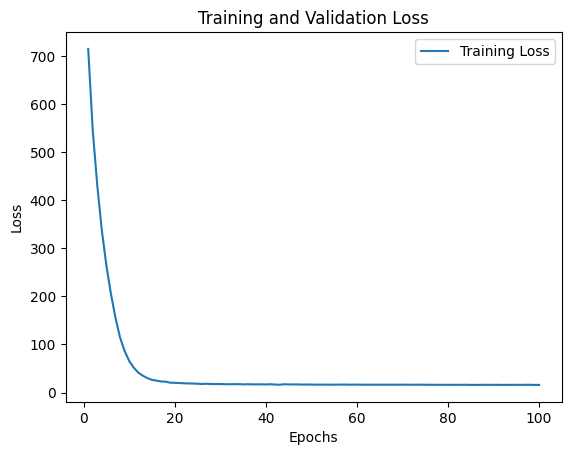

In [105]:
# Plot loss over epochs
epochs = np.array(range(1, epoch+2))

plt.plot(epochs, epoch_train_loss, label='Training Loss')
#plt.plot(epochs, epoch_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
sos = torch.tensor([1])
eos = torch.tensor([2])

'''
Photos from training data
3681172959.jpg
51780996.jpg
'''

#image_id = 'test_030.jpg'
image_id = '3512747808.jpg'
prompt = 'Two'

# Preprocess images and captions
image_encoded = preprocess_image(image_id)
image_input = torch.tensor(image_encoded).unsqueeze(dim=0)

if prompt == '':
    decoder_input = sos.unsqueeze(dim=0)
else:
    decoder_input = torch.cat([sos, torch.tensor(sp.encode(prompt))]).unsqueeze(dim=0)


while True:
    '''
    print("IN WHILE LOOP")
    print(image_input.shape)
    print(image_input)
    print(decoder_input.shape)
    print(decoder_input)
    '''

    p_all = transformer(image_input, decoder_input)
    p_last = p_all[:, -1, :]
    p_last = torch.nn.functional.softmax(p_last, dim=1)
    p_last = torch.argmax(p_last, dim=1).unsqueeze(dim=0)

    decoder_output = torch.cat((decoder_input, p_last), dim=1)

    if (decoder_output[0, -1] == 2) or (decoder_output.size(1) == max_seq_length):
        break
    else:
        decoder_input = decoder_output.clone()

decoder_output = decoder_output.squeeze().tolist()
print("Generate:", sp.decode(decoder_output))

Generate: Two in progress in a partial stadium with many people, with many people, with a large building in the background.


#STUFF TO PULL CODE FROM

In [ ]:
def preprocess_image(path, img_size, patch_size):

    # Pre-processing image as an array of normalized pixel values
    img = Image.open(path).resize((img_size, img_size))
    img_array = np.array(img)
    img_array = img_array / 255.0

    # reshape into patches
    patch_height = img_array.shape[0] // patch_size
    patch_width = img_array.shape[1] // patch_size
    patches = np.reshape(img_array, (patch_height, patch_size, patch_width, patch_size, img_array.shape[2]))
    patches = np.transpose(patches, (0, 2, 1, 3, 4))
    patches = np.reshape(patches, (-1, patch_size, patch_size, img_array.shape[2]))

    # Flatten the patches
    patches = np.reshape(patches, (patches.shape[0], -1))
    patches = np.expand_dims(patches, axis=0)  # Added dimension to specify batch size

    return patches


def load_images(path, img_size=256, patch_size=16):
    # Create a dictionary of pre-processed images indexed by image id
    images = {}

    # List all files in the directory
    files = listdir(path)

    # Filter out files that are not JPEG images
    image_files = [file for file in files if file.lower().endswith('.jpg')]

    for name in tqdm(image_files):
        filename = join(path, name)
        images[name] = preprocess_image(filename, img_size, patch_size)

    return images


# Load images
image_path = 'Images/flickr30k_images/'
images = load_images(image_path)
print(f'Number of loaded images: {len(images)}')


In [ ]:
# Save preprocessed images to pickle
pickle.dump(images,
            open(f'{working_directory}preprocessed_images.pkl', 'wb'))

In [ ]:
def preprocess_text(caption_string):
    # Convert string of captions into a list
    caption_list = eval(caption_string)



    '''
    # Use regular expressions to pre-process a caption
    caption = caption.lower()                     # converts to lower case
    caption = re.sub(r'[^a-z\s]', ' ', caption)   # retains a-z and spaces
    caption = re.sub(r'\b\w\b', '', caption)      # remove single char tokens
    caption = re.sub(r'^', 'startseq ', caption)  # adds a tag at the start
    caption = re.sub(r'$', ' endseq', caption)    # adds a tag at the end
    caption = re.sub(r'\s+', ' ', caption)        # deletes excess space
    '''

    return caption_list


# Load and pre-process image captions
annotations = pd.read_csv(annotations_path)
annotations.raw = annotations.raw.apply(preprocess_text)

# Load images from pickle
with open(f'{working_directory}preprocessed_images_1.pkl', 'rb') as f:
    images = pickle.load(f)

# Create an array of captions that correspond to each image and save as a
# dictionary with image id as the index. Create dictionaries for each of the
# train, validate and test datasets
captions, train_captions, val_captions, test_captions = {}, {}, {}, {}

for image in images.keys():
    print(image)
    print(annotations)
    if image not in captions.keys():
        captions[image] = annotations[image][0]










'''
count = 0
for key, value in captions.items():
    # Print the key-value pair
    print(key, value)
    # Increment the counter
    count += 1
    # Check if we have printed 20 rows
    if count == 20:
        break


    if row.image in encoded_train_images:
        captions_dict = train_captions
    elif row.image in encoded_val_images:
        captions_dict = val_captions
    elif row.image in encoded_test_images:
        captions_dict = test_captions
    else:
        continue

    if row.image not in captions_dict:
        captions_dict[row.image] = []
    captions_dict[row.image].append(row.caption)
'''

# Save captions to pickle
pickle.dump(captions,
            open(f'{working_directory}preprocessed_captions_1.pkl', 'wb'))

'''
pickle.dump(train_captions,
            open(f'{working_directory}train_captions.pkl', 'wb'))
pickle.dump(val_captions,
            open(f'{working_directory}val_captions.pkl', 'wb'))
pickle.dump(test_captions,
            open(f'{working_directory}test_captions.pkl', 'wb'))

# Check results
pd.set_option('display.max_colwidth', None)
print(data.caption[:10])
print('\nNumber of total caption arrays (= num total images):',
      len(captions))
print('Number of training set captions (= num train dataset images):',
      len(train_captions))
print('Number of validation set captions (= num validation dataset images):',
      len(val_captions))
print('Number of test set captions (= num test dataset images):',
      len(test_captions))

'''